## Cobot Projectile Obstacle Avoidance
Work Items:
1. Obstacle generator
2. YOLO image segmentation
3. Cobot control and DQN

In [1]:
import pybullet as p
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import cobot_ai4robotics
import math

In [2]:
# Hyperparameters.
EPISODES = 301 # Keep low at a modest number to start with. Can load and save to do more episodes.
LEARNING_RATE = 0.00025 
MEM_SIZE = 20000
REPLAY_START_SIZE = 1000
BATCH_SIZE = 64#32 # Try upping the batch size for more complex space.
GAMMA = 0.99 # Discount factor.
EPS_START = 0.1
EPS_END = 0.0001
EPS_DECAY = 4 * MEM_SIZE
MEM_RETAIN = 0.1
NETWORK_UPDATE_ITERS = 200

FC1_DIMS = 512
FC2_DIMS = 256

# Training status metrics.
best_reward = 0
average_reward = 0
episode_history = []
episode_reward_history = []
max_ep_reward = []
np.bool = np.bool_

# Classes using deep Q-Learning to teach the robot to drive to the goal.
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

#____________________________________________________DQN_STRUCTURE_____________________________________________________________________________#

# Class to define network structure for the target and policy networks. They MUST be of the same structure.
class Network(torch.nn.Module):
    # Initialise the network's structure.
    def __init__(self, env):
        super().__init__()
        self.input_shape = env.observation_space.shape[0]
        self.action_space = env.action_space.n

        # Network of hidden layers, number and structure tbd.
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_shape, FC1_DIMS),
            torch.nn.ReLU(),
            torch.nn.Linear(FC1_DIMS, FC2_DIMS),
            torch.nn.ReLU(),
            torch.nn.Linear(FC2_DIMS, self.action_space)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE) # No need to pick out a better optimiser, assume that this will do the job.
        self.loss = nn.MSELoss() # Using mean squared error as the loss. Should be alright without considering a different loss function.
    
    # Pass the states into the network to return a weighted list of action responses.
    def forward(self, x):
        return self.layers(x)
    
    #____________________________________________________REPLAY_BUFFER_____________________________________________________________________________#

# The replay buffer is used to store a dataset of the agent's experiences so it can be randomly sampled in batches to learn from.
class ReplayBuffer:
    # Initialise memory space for states, actions, rewards, next_states, and done flags.
    def __init__(self, env):
        self.mem_count = 0
        self.states = np.zeros((MEM_SIZE, env.observation_space.shape[0]), dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, env.observation_space.shape[0]), dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)
    
    # Add an experience to the Replay Buffer.
    def add(self, state, action, reward, state_, done):
        if self.mem_count < MEM_SIZE:
            mem_index = self.mem_count
        else: # Attempt to avoid catastrophic forgetting by retaining a portion of the dataset when the replay buffer is full and needs to be cleared.
            mem_index = int(MEM_SIZE*MEM_RETAIN)
            self.mem_count = mem_index
            print("Overwriting Replay memory from", mem_index)

        # Add experience to specified mem_index entry.
        #print(state[0], self.states.shape)
        self.states[mem_index] = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] = 1 - done 

        self.mem_count += 1 # Increment index by 1 for next experience.

        # if (self.mem_count % 100) == 0:
        #     print("Memory Count: ", self.mem_count)

    # Return a random sample from the replay buffer of size BATCH_SIZE.
    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        # Get indices of size BATCH_SIZE from the replay buffer of current size MEM_MAX to train on.
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True) # Replace - you can select the same value more than once (returned to sample pool after being chosen).

        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones = self.dones[batch_indices]

        return states, actions, rewards, states_, dones
    
#____________________________________________________DQN_SOLVER_____________________________________________________________________________#
class DQN_Solver:
    def __init__(self, env, load=None):
        self.memory = ReplayBuffer(env) # Access the replay buffer through the self.memory variable.
        self.policy_network = Network(env) # The Q or policy network.
        if load != None: # Load given model.
            self.policy_network.load_state_dict(torch.load(load))
        self.target_network = Network(env) # The Q^ or target network (its hat fell off a bit...)
        self.target_network.load_state_dict(self.policy_network.state_dict()) # When we initialise, have the target network copy the policy network's weights.
        self.learn_count = 0 # Iterations we have learnt for.
    
    # Our epsilon greedy function responsible for choosing actions as we learn. 
    def choose_action(self, observation):
        if self.memory.mem_count > REPLAY_START_SIZE:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.learn_count / EPS_DECAY)
        else:
            eps_threshold = 1.0

        # If we roll a value lower than eps_threshold, take a random action in the action_space.
        # As part of part 2, we must use prior knowledge to set a non-uniform probability distribution for which random actions we take.
        if random.random() < eps_threshold:             #
            return np.random.choice(np.array(range(7)), p=[1/21,  4/21,  4/21,  4/21,  4/21,
                                                            2/21,  2/21])# p=[1/45, 1/45, 1/45, 1/45, 1/45, 1/45, 1/45, 27/45, 1/45]) # there are 9 actions (0-8). p = [probabilities * 9]
        
        # If we pass the random check and are past the initial filling of the replay buffer, begin to take intelligent action.
        state = torch.tensor(observation).float().detach()
        state = state.unsqueeze(0)
        self.policy_network.eval() # Sets the network into evaluation mode.
        with torch.no_grad(): # Disable gradient computation for the forward pass.
            q_values = self.policy_network.forward(state) # Given the state, get Q values for each action.
        return torch.argmax(q_values).item() # Return the action with the highest Q value.
    
    # Training Loop
    def learn(self):
        states, actions, rewards, states_, dones = self.memory.sample() # Random sample of BATCH_SIZE from replay buffer.
        states = torch.tensor(states , dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        states_ = torch.tensor(states_, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        self.policy_network.train(True) # Sets the network into training mode.
        q_values = self.policy_network(states)  # First, q_values for all sampled experiences and all actions.
        q_values = q_values[batch_indices, actions] # Then, q_values for all sampled experiences and select actions. Check this?

        self.target_network.eval() # Evaluation mode for target network.
        with torch.no_grad():
            q_values_next = self.target_network.forward(states_)

        q_values_next_max = torch.max(q_values_next, dim=1)[0] # The maximum q values for the next state.

        q_target = rewards + GAMMA * q_values_next_max * dones # Target Q value.

        # Calculate loss on new q_values (policy network) and q_target (target_network).
        loss = self.policy_network.loss(q_values, q_target)

        # SGD.
        self.policy_network.optimizer.zero_grad() # Zero the gradient to prevent accumulation.
        loss.backward()
        self.policy_network.optimizer.step()
        self.learn_count += 1

        # Target network's weights should be set to policy network's weights every so often to keep learning with some stability.
        if self.learn_count % NETWORK_UPDATE_ITERS == NETWORK_UPDATE_ITERS -1:
            print("Updating Target Network")
            self.update_target_network()

    # Set Q^ = Q every so often.
    def update_target_network(self): 
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def returning_epsilon(self): # Is this even needed?
        return self.exploration_rate

## Training Section

In [3]:
# Training DQN.
env = gym.make("cobot_ai4robotics", apply_api_compatibility=True, renders=True, isDiscrete=True, debug=0)

# Seed setting. Choose any number that makes you happy :)
# env.action_space.seed()
# random.seed()
# np.random.seed()
# torch.manual_seed()
episode_batch_score = 0
episode_reward = 0

# Comment and uncomment to pick whether to start a new model or train an existing one.
agent = DQN_Solver(env)
agent = DQN_Solver(env, load="project_policy_network.pkl")
plt.clf() # Clear current figure.
goal_count = 0

# Training loop.
print("No. of eps: ", EPISODES)
for i in range(EPISODES):
    print("Episode", i)
    state, _ = env.reset()
    while True: #for j in range(300): # Set finite life for each EPISODE?
        # Loopa
        action = agent.choose_action(state)
        state_, reward, done, _, info = env.step(action)

        # New reward scheme per part 3.
        # Reward for reaching goal has been added to env.step in the gym environment.
        # if done: # Reached goal.
        #     reward = 50
        agent.memory.add(state, action, reward, state_, done)

        if agent.memory.mem_count > REPLAY_START_SIZE:
            agent.learn()
        
        state = state_ # Move current state to new state positions.
        episode_batch_score += reward
        episode_reward += reward

        if done & (reward > 0): # Count the number of episodes for which we reach the goal.
            goal_count += 1
            reward = 0 # Represent reward as distance in final graph.

        if done: # If we reached the goal, we can leave early.
            max_ep_reward.append(reward)
            break

    episode_history.append(i)   # Append episode number for plotting.
    episode_reward_history.append(episode_reward) # Append overall episode reward for plotting.

    print(agent.memory.mem_count, episode_reward)

    episode_reward = 0.0    # Reset episode reward for next round.

    # Save model progress every n batches.
    if i % 100 == 0 and agent.memory.mem_count > REPLAY_START_SIZE:
        torch.save(agent.policy_network.state_dict(), "project_policy_network.pkl")
        print("average total reward per episode batch since episode ", i, ": ", episode_batch_score/ float(100))
        episode_batch_score = 0
    elif agent.memory.mem_count < REPLAY_START_SIZE:
        #print("waiting for buffer to fill...")
        episode_batch_score = 0
print("Successful Episodes:", goal_count, "/", EPISODES)
plt.plot(episode_history, episode_reward_history)
plt.show()

env.close()

YOLO LOADED
No. of eps:  301
Episode 0


c:\Users\mvsue\miniconda3\envs\Ai4Robotics_FinalProject\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\mvsue\miniconda3\envs\Ai4Robotics_FinalProject\lib\site-packages\gym\utils\passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
c:\Users\mvsue\miniconda3\envs\Ai4Robotics_FinalProject\lib\site-packages\gym\spaces\box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


Contact on table at point (0.75 0.27 0.62) on KUKA.
32 -89.6
Episode 1
Contact on table at point (0.75 -0.35 0.62) on KUKA.
49 -99.5
Episode 2
Contact on table at point (0.65 -0.21 0.62) on KUKA.
56 -100.0
Episode 3
Contact on table at point (0.75 0.30 0.58) on KUKA.
67 -100.0
Episode 4
Contact on table at point (0.66 -0.24 0.62) on KUKA.
74 -100.0
Episode 5
Contact on table at point (0.74 0.16 0.62) on KUKA.
82 -100.0
Episode 6
Contact by ball no. 0 at point (1.05 -0.32 1.16) on KUKA.
100 -98.0
Episode 7
Contact on table at point (0.75 -0.34 0.62) on KUKA.
123 -93.4
Episode 8
Contact on table at point (0.58 -0.50 0.62) on KUKA.
144 -94.1
Episode 9
Contact on table at point (0.75 -0.19 0.62) on KUKA.
179 -93.5
Episode 10
Contact on table at point (0.75 0.09 0.62) on KUKA.
205 -92.1
Episode 11
Contact on table at point (0.66 -0.17 0.62) on KUKA.
212 -100.0
Episode 12
Contact on table at point (0.68 -0.05 0.62) on KUKA.
219 -100.0
Episode 13
Contact on table at point (0.75 0.32 0.62) on 

Successful Episodes: 522 / 1201


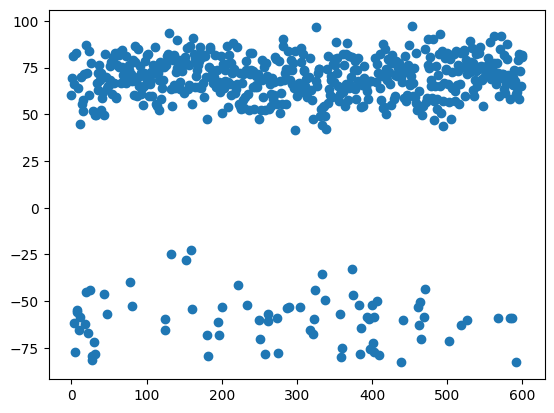

In [ ]:
print("Successful Episodes:", goal_count, "/", EPISODES)
plt.scatter(episode_history, episode_reward_history)
plt.show()

## Demo Section

In [ ]:
# Basic code to open the GUI environment window.
# https://www.gymlibrary.dev/content/environment_creation/ - make a custom gym environment.
# env.reset()
env = gym.make("cobot_ai4robotics", apply_api_compatibility=True, renders=True, isDiscrete=True, debug=0)
agent = DQN_Solver(env)
agent.policy_network.load_state_dict(torch.load("project_policy_network.pkl"))
# agent.policy_network.eval()

ob, _ = env.reset()

# Modify joint control so that it is a change to the current joint position, not specifying a joint position.
while True:
    with torch.no_grad():
        q_values = agent.policy_network(torch.tensor(ob, dtype=torch.float32))
    action = torch.argmax(q_values).item()
    ob, reward, done, _, info = env.step(action)
    # ob, reward, done, _, info = env.step(env.action_space.sample()) # Things will not move unless you call env.step.
    # ob, reward, done, _, info = env.step(3)
    # print(env.action_space.sample())
    # print(ob)
    # print(reward)
    if done:
        if reward > 0:
            print("Success!")
        # break
        env.reset()
env.close()

YOLO LOADED
Contact on table at point (0.75 0.28 0.62) on KUKA.
Contact by ball no. 1 at point (0.71 0.16 1.56) on KUKA.
Contact by ball no. 1 at point (0.54 -0.11 1.45) on KUKA.
Success!
Contact by ball no. 2 at point (0.71 0.14 1.55) on KUKA.
Success!
Contact by ball no. 1 at point (0.56 0.03 1.50) on KUKA.
Contact by ball no. 0 at point (0.38 -0.01 1.37) on KUKA.
Contact by ball no. 1 at point (0.69 -0.16 1.57) on KUKA.


In [ ]:
env.close()